In [1]:
import pickle
import numpy as np
import pandas as pd
import requests
import math
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Loading Data:

In [279]:
with open('per_season_mlb_eda_ready.pkl', 'rb') as handle:
    df = pickle.load(handle)

In [280]:
#lets make sure there are no nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1151 entries, Larry Barnes to Lenny Webster
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MINORS_OPS               1151 non-null   float32
 1   MLB_AB_per_season        1151 non-null   float64
 2   MINORS_R_per_AB          1151 non-null   float64
 3   MINORS_SO_per_AB         1151 non-null   float64
 4   Draft                    1151 non-null   float64
 5   School                   1151 non-null   float64
 6   Debut_Age                1151 non-null   float64
 7   Position_Catcher         1151 non-null   float64
 8   Position_First_Baseman   1151 non-null   float64
 9   Position_Outfielder      1151 non-null   float64
 10  Position_Second_Baseman  1151 non-null   float64
 11  Position_Shortstop       1151 non-null   float64
 12  Position_Third_Baseman   1151 non-null   float64
 13  Bats_Both                1151 non-null   float64
 14  Bats_Left

In [281]:
#splitting the data into X and Y and train and test
X, y = df.drop(columns =['MLB_AB_per_season']), df['MLB_AB_per_season']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 12)
model = sm.OLS(y_train, X_train)
fit1 = model.fit()

In [282]:
#ok so lets take look at the initial model
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      MLB_AB_per_season   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     37.80
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           1.05e-80
Time:                        15:24:55   Log-Likelihood:                -5732.3
No. Observations:                 920   AIC:                         1.149e+04
Df Residuals:                     905   BIC:                         1.157e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
MINORS_OPS                334.0713    101.938      3.277      0.001     134.009     534.133
MINORS_R_per_AB           764.6246    314.650      2.430      0.015     147.097    1382.153
MINORS_SO_per_AB         -749.7254     82.624     -9.074      0.000    -911.883    -587.568
Draft                      -0.8849      0.314     -2.815      0.005      -1.502      -0.268
School                     36.0047     10.312      3.491      0.001      15.766      56.244
Debut_Age                 -30.2677      2.049    -14.769      0.000     -34.290     -26.246
Position_Catcher          169.6802     29.431      5.765      0.000     111.920     227.441
Position_First_Baseman    186.2457     34.378      5.418      0.000     118.777     253.715
Position_Outfielder       182.4739     29.607      6.163      0.000     124.368     240.579
Position_Second_Baseman   187.6827     29.462      6.370      0.000     129.862     245.504
Position_Shortstop        197.4597     26.061      7.577      0.000     146.312     248.608
Position_Third_Baseman    183.8767     30.795      5.971      0.000     123.440     244.314
Bats_Both                 373.9292     56.201      6.653      0.000     263.629     484.230
Bats_Left                 370.1572     56.335      6.571      0.000     259.594     480.720
Bats_Right                363.3326     56.647      6.414      0.000     252.157     474.508
bmi                         5.3225      1.912      2.784      0.005       1.570       9.075
==============================================================================
Omnibus:                       38.739   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.914
Skew:                           0.364   Prob(JB):                     1.94e-07
Kurtosis:                       2.473   Cond. No.                     3.43e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.14e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [283]:
lm_test_set_pred = fit1.predict(X_test)
r2_score(y_test, lm_test_set_pred)

0.39984652519962416

**Ok lets see if we can do better with Lasso and Ridge**

# Cross Validation and Model Selection

In [284]:
#changing X and Y to arrays for k folds
X, y = np.array(X), np.array(y)

### Ridge vs. Regular Linear Regression

In [285]:
# Let's find the best alpha for Ridge first
alpha_vec = np.linspace(0.001,1.0, num=1000)
best_alpha = RidgeCV(alpha_vec).fit(X,y).alpha_
best_alpha

0.045

In [286]:
from sklearn.model_selection import cross_val_score

#initializing K folds
kf = KFold(n_splits=5, shuffle=True, random_state = 13)

#setting up both models
lm = LinearRegression()
lm_reg = Ridge(alpha=best_alpha)

print(f'Simple mean cv r^2: {np.mean(cross_val_score(lm,X,y,cv=kf)):.3f} +- {np.std(cross_val_score(lm,X,y,cv=kf)):.3f}')

#ridge with feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test) # save for later

print(f'Ridge mean cv r^2: {np.mean(cross_val_score(lm, X,y,cv=kf)):.3f} +- {np.std(cross_val_score(lm_reg, X_scaled,y,cv=kf)):.3f}')


Simple mean cv r^2: 0.364 +- 0.025
Ridge mean cv r^2: 0.364 +- 0.025


In [287]:
#lets look at the coefficients for the Ridge model
fitted_ridge = lm_reg.fit(X_scaled,y)
list(zip(df.drop(columns =['MLB_AB_per_season']).columns, fitted_ridge.coef_))

[('MINORS_OPS', 25.955659962647584),
 ('MINORS_R_per_AB', 17.325978466620306),
 ('MINORS_SO_per_AB', -39.343301299757044),
 ('Draft', -11.183583422961945),
 ('School', 16.789839724411273),
 ('Debut_Age', -71.48616172746597),
 ('Position_Catcher', -4.855989015832516),
 ('Position_First_Baseman', 2.467183741392258),
 ('Position_Outfielder', -0.9215998560912823),
 ('Position_Second_Baseman', 1.7686286896773704),
 ('Position_Shortstop', 3.1859781241490257),
 ('Position_Third_Baseman', -0.7357271305412407),
 ('Bats_Both', 2.9530230423106163),
 ('Bats_Left', -1.315538935322424),
 ('Bats_Right', -0.9099511910411382),
 ('bmi', 10.246526586005109)]

In [288]:
#and lets look at the R^2 value for the Ridge model
ridge_test_set_pred = fitted_ridge.predict(X_test_scaled)
r2_score(y_test, ridge_test_set_pred)

0.40859042036824467

**Interesting. We got a slightly higher R^2 than the OLS model. This is probably just due to random chance though because the mean R^2 value for ridge was the same as OLS.**

### Lasso

In [289]:
#Let's find the best alpha for Lasso first
alpha_vec = np.linspace(0.001,1.0, num=1000)
best_lasso_alpha = LassoCV(alphas=alpha_vec, cv=kf).fit(X,y).alpha_
best_lasso_alpha

0.006

In [290]:
#setting up both models
lm = LinearRegression()
lasso_model = Lasso(alpha = best_lasso_alpha)

print(f'Regular Regression mean cv r^2: {np.mean(cross_val_score(lm,X,y,cv=kf)):.3f} +- {np.std(cross_val_score(lm,X,y,cv=kf)):.3f}')

#lasso with feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test) # saving for later

print(f'Lasso mean cv r^2: {np.mean(cross_val_score(lasso_model, X_scaled,y,cv=kf)):.3f} +- {np.std(cross_val_score(lasso_model, X_scaled,y,cv=kf)):.3f}')

Regular Regression mean cv r^2: 0.364 +- 0.025
Lasso mean cv r^2: 0.364 +- 0.025


/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84758.81758115813, tolerance: 2235.5795855611204
  positive)
/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87567.89830373973, tolerance: 2227.1438316939357
  positive)
/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85190.3274239488, tolerance: 2229.149410381134
  positive)
/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: O

**Wow again the lasso model is basically indistinguishable from the regular regression model.**

In [291]:
#lets look at the coefficients for the Ridge model
list(zip(df.drop(columns =['MLB_AB_per_season']).columns, lasso_model.fit(X_scaled,y).coef_))

/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103594.52274969779, tolerance: 2766.4649508514635
  positive)


[('MINORS_OPS', 25.951889623472297),
 ('MINORS_R_per_AB', 17.325029361394087),
 ('MINORS_SO_per_AB', -39.33956444337601),
 ('Draft', -11.17280329731318),
 ('School', 16.77717590742203),
 ('Debut_Age', -71.48177650938528),
 ('Position_Catcher', -4.800702340055638),
 ('Position_First_Baseman', 2.506231266456685),
 ('Position_Outfielder', -0.8527063189187049),
 ('Position_Second_Baseman', 1.8065534006128603),
 ('Position_Shortstop', 3.229632735203481),
 ('Position_Third_Baseman', -0.6844002821336633),
 ('Bats_Both', 3.596741471584726),
 ('Bats_Left', -0.484165821962132),
 ('Bats_Right', 0.0),
 ('bmi', 10.238823786558521)]

In [292]:
#and lets look at the R^2 value for the Ridge model
fitted_lasso = lasso_model.fit(X_scaled,y)
test_set_pred = fitted_lasso.predict(X_test_scaled)

/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103594.52274969779, tolerance: 2766.4649508514635
  positive)


In [293]:
r2_score(y_test, test_set_pred)

0.4085878098642626

**We also got a slightly higher R^2 here but it's pretty crazy to see that the Lasso and Ridge models have pretty much the exact same R^2 values. Maybe this is because of all the feature engineering I did before starting this process.**

# Taking out outliers

**Lasso and Ridge didn't really make much of a difference. Clearly predicting MLB ABs from minor league stats is difficult. Maybe it could help if we take out the outliers from the data. Also please note that this code on taking out outliers was taken from Kevin Chiv's Altmetric analysis: https://github.com/kevinchiv/Predicting-Altmetric-Score**

In [275]:
#setting up higher and lower bounds of data
q1 = df['MLB_AB_per_season'].quantile(.25)
q3 = df['MLB_AB_per_season'].quantile(.75)
iqr = q3 - q1

lower_bound = q1
upper_bound = q3 + 100

#applying a mask based on the higher and lower bounds of data
quartile_mask = df['MLB_AB_per_season'].between(lower_bound, upper_bound, inclusive=True)
allowed_idx = df.loc[quartile_mask, 'MLB_AB_per_season'].index
df_copy = df[df.index.isin(allowed_idx)]

#training the model on this limited dataset
X, y = df_copy.drop(columns = ['MLB_AB_per_season']), df_copy['MLB_AB_per_season']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 12)

model = sm.OLS(y_train, X_train)
fit = model.fit()

y_pred = fit.predict(X_test)
print('R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

fit.summary()

R^2 Score for Test: 0.25


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      MLB_AB_per_season   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     10.14
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           1.52e-20
Time:                        15:20:47   Log-Likelihood:                -3589.4
No. Observations:                 594   AIC:                             7209.
Df Residuals:                     579   BIC:                             7275.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
MINORS_OPS                 46.0720    110.153      0.418      0.676    -170.277     262.421
MINORS_R_per_AB           902.0861    337.541      2.673      0.008     239.133    1565.039
MINORS_SO_per_AB         -470.9075     87.944     -5.355      0.000    -643.636    -298.179
Draft                      -0.5859      0.324     -1.810      0.071      -1.222       0.050
School                     16.4986     10.955      1.506      0.133      -5.017      38.014
Debut_Age                 -20.1825      2.471     -8.168      0.000     -25.036     -15.329
Position_Catcher          156.9168     32.190      4.875      0.000      93.694     220.139
Position_First_Baseman    165.4214     37.386      4.425      0.000      91.993     238.849
Position_Outfielder       166.5704     32.585      5.112      0.000     102.570     230.570
Position_Second_Baseman   163.7099     33.048      4.954      0.000      98.801     228.618
Position_Shortstop        170.3413     28.257      6.028      0.000     114.842     225.840
Position_Third_Baseman    182.2970     33.488      5.444      0.000     116.524     248.070
Bats_Both                 329.8190     61.615      5.353      0.000     208.803     450.835
Bats_Left                 338.4741     61.947      5.464      0.000     216.806     460.142
Bats_Right                336.9637     63.014      5.347      0.000     213.199     460.728
bmi                         4.1796      2.070      2.019      0.044       0.113       8.246
==============================================================================
Omnibus:                       77.812   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.697
Skew:                           0.194   Prob(JB):                     7.15e-06
Kurtosis:                       2.101   Cond. No.                     3.00e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.55e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Thoughts:**

**Taking out outliers made things worse somehow! It did make Runs per AB have way more of an effect than anything else though. Interesting**

# Conclusions and Plots

**Since all the models are about the same I could probably pick any of them. However, I pick Ridge because the R^2 is slightly higher from the test. The OLS also has colinearity problems and Ridge is known to fix that so I think the Ridge model is probably the most accurate**

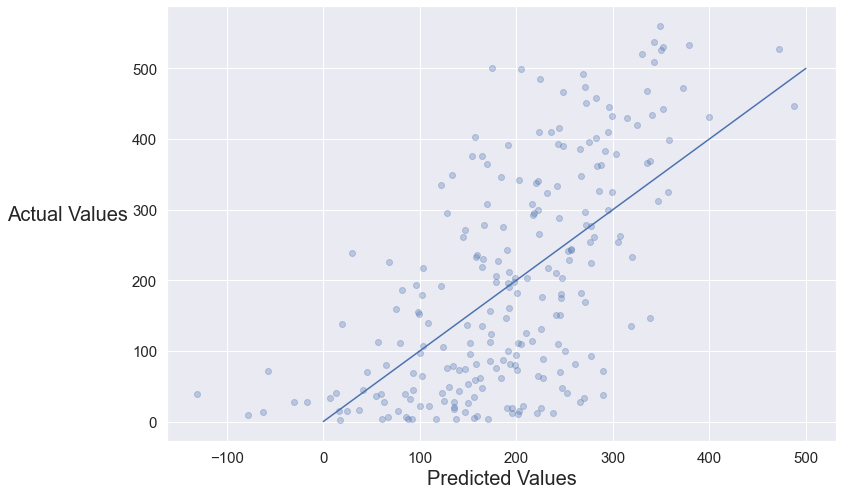

In [306]:
#plotting the ridge predicted values versus the actual values
plt.figure(figsize=(12,8))
plt.scatter(ridge_test_set_pred, y_test, alpha=.3)
plt.plot(np.linspace(0,500,50), np.linspace(0,500,50))
plt.xlabel('Predicted Values', fontsize=20)
plt.ylabel('Actual Values', fontsize=20, rotation='horizontal', horizontalalignment='right')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('actualvspredicted.png',format='png',bbox_inches='tight')

In [299]:
ridge_residuals = y_test - ridge_test_set_pred

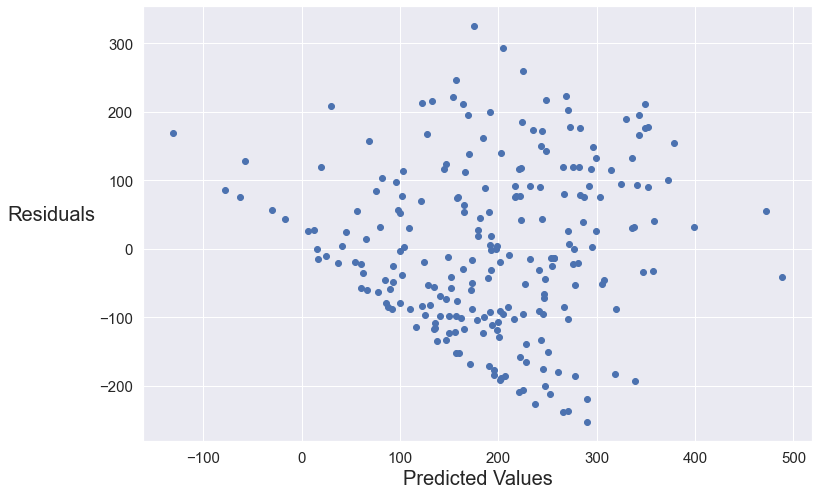

In [311]:
plt.figure(figsize=(12,8))
plt.scatter(ridge_test_set_pred, ridge_residuals)
plt.xlabel('Predicted Values', fontsize=20, verticalalignment='top')
plt.ylabel('Residuals', fontsize=20, rotation='horizontal', horizontalalignment='right')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('residuals.png',format='png',bbox_inches='tight')

Unfortunately, there is still some hetereoskedascity here. The higher the predicted values the closer they tend to be to the actual value. The model is still failing to understand the full cause of why some players have more MLB AB than others.